In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import convolve
from scipy.ndimage import imread
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy.io import loadmat
from scipy.ndimage import map_coordinates
from scipy.sparse import csr_matrix
from scipy.sparse import dia_matrix
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import bicg
from scipy.sparse import find
from scipy.misc import imresize
from helpers import *
import cv2

In [2]:
def photo_loss(im1, im2, uv):
    return np.mean(np.sum(np.square(warp(im2, uv) - im1), axis=-1))

def warp(im, uv):
    H, W, C = im.shape
    x, y = np.meshgrid(range(W), range(H))
    x, y = x.astype(np.float32), y.astype(np.float32)
    x2 = x + uv[:,:,0]
    y2 = y + uv[:,:,1]

    return np.dstack([
        map_coordinates(im[:,:,i], [y2.ravel(), x2.ravel()], mode='mirror').reshape((H, W)) for i in range(C)
    ])

In [3]:
def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()

print fspecial_gauss(5, 1)

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


In [4]:
# convolution for RGB images
def myconvolve(im, f):
    return np.dstack([
        convolve(im[:,:,i], f) for i in range(3)
    ])

def smooth_loss(u, v, segmentation):    
    grid_kernels = [[[0,0,0],
               [0,1,-1],
               [0,0,0]],
              [[0,-1,0],
               [0,1,0],
               [0,0,0]],
              [[0,0,0],
               [-1,1,0],
               [0,0,0]],
              [[0,0,0],
               [0,1,0],
               [0,-1,0]]]
    
    udx = convolve(u, grid_kernels[0])
    udy = convolve(u, grid_kernels[1])
    vdx = convolve(v, grid_kernels[2])
    vdy = convolve(v, grid_kernels[3])
    
    if segmentation is not None:
        udx = udx * (1 - np.abs(convolve(segmentation, grid_kernels[0])) )
        udy = udy * (1 - np.abs(convolve(segmentation, grid_kernels[1])) )
        vdx = vdx * (1 - np.abs(convolve(segmentation, grid_kernels[2])) )
        vdy = vdy * (1 - np.abs(convolve(segmentation, grid_kernels[3])) )
        print np.unique( 1 - np.abs(convolve(segmentation, grid_kernels[3])) )

    return np.mean(udx**2 + udy**2 + vdx**2 + vdy**2)

def resample_flow(uv, sz):
    ratio = sz[0] / uv.shape[0]
    u = uv[:,:,0]
    v = uv[:,:,1]
    #u = imresize(u, sz)
    u = cv2.resize(u, (sz[1], sz[0]))*ratio
    v = cv2.resize(v, (sz[1], sz[0]))*ratio
    return np.concatenate([np.expand_dims(u, -1),np.expand_dims(v, -1)], axis=-1)

def compute_image_pyramid(images, f, nL, ratio):
    P = [];
    tmp = images;
    P.append(tmp)
    for m in range(1, nL):
        tmp = np.concatenate([
            np.expand_dims(myconvolve(tmp[:,:,:,0], f), -1),
            np.expand_dims(myconvolve(tmp[:,:,:,1], f), -1)], axis=-1)
        tmp = np.concatenate([
            np.expand_dims(imresize(tmp[:,:,:,0], ratio).astype('float32'), -1),
            np.expand_dims(imresize(tmp[:,:,:,1], ratio).astype('float32'), -1)], axis=-1)
        P.append(tmp)
    return P

In [5]:
class HornSchunck:
    
    def __init__(self):
        self.weightsmoothness = 10000
        self.pyramid_levels = 1
        self.pyramid_spacing = 2.0
        self.max_iters = 30
        self.max_linear = 1
        self.solver = 'bicgstab'
        # if segmentation is provided
        self.segmentation = None
    
    def partial_deriv(self, im1, im2, uv):
        warpIm = warp(im2, uv)

        kernelX = np.array([[-1, 9, -45, 0, 45, -9, 1]],dtype=np.float32) /60 #kernel for computing d/dx
        kernelY = kernelX.transpose()

        Ix = myconvolve(warpIm,-1*kernelX)
        Iy = myconvolve(warpIm,-1*kernelY)

        It = warpIm - im1

        return It,Ix,Iy
    
    def getAsmooth(self, H, W):
        grid_kernels = np.array([
        [
            [0, 0, 0],
            [0, 1, -1],
            [0, 0, 0]
        ], [
            [0, -1, 0],
            [0, 1, 0],
            [0, 0, 0]
        ], [
            [0, 0, 0],
            [-1, 1, 0],
            [0, 0, 0]
        ], [
            [0, 0, 0],
            [0, 1, 0],
            [0, -1, 0]
        ]
        ])
        
        if self.segmentation is not None:
            segmentation_small = cv2.resize(self.segmentation.astype(np.uint8), (W, H)).astype(np.int32)
            mask0 = 1 - np.square(convolve(segmentation_small, grid_kernels[0]))
            mask1 = 1 - np.square(convolve(segmentation_small, grid_kernels[1]))
            mask2 = 1 - np.square(convolve(segmentation_small, grid_kernels[2]))
            mask3 = 1 - np.square(convolve(segmentation_small, grid_kernels[3]))
        else:
            mask0 = np.ones((H,W),dtype=np.int32)
            mask1 = np.ones((H,W),dtype=np.int32)
            mask2 = np.ones((H,W),dtype=np.int32)
            mask3 = np.ones((H,W),dtype=np.int32)
        
        m0 = np.concatenate((mask0[:,1:W], np.zeros((H, 1))), axis=1)
        m1 = np.concatenate((np.zeros((1, W)), mask1[0:(H-1),:]), axis=0)
        m2 = np.concatenate((np.zeros((H, 1)), mask2[:,0:(W-1)]), axis=1)
        m3 = np.concatenate((mask3[1:H,:], np.zeros((1, W))), axis=0)

        normalizer = m0 + m1 + m2 + m3
        normalizer[normalizer == 0] = 4

        npixels = H * W
        shp = (npixels, npixels)

        # Can be merged into a single `dia_matrix` call
        A0 = dia_matrix((np.concatenate((np.array([0]), -m0.ravel())), 1), shape=shp)
        A1 = dia_matrix((-m1.ravel()[W:], -W), shape=shp)
        A2 = dia_matrix((-m2.ravel()[1:], -1), shape=shp)
        A3 = dia_matrix((np.concatenate((np.repeat(0, W), -m3.ravel())), W), shape=shp)

        A = A0 + A1 + A2 + A3 + dia_matrix((normalizer.ravel(), 0), shape=shp)

        A2 = dia_matrix((2*npixels, 2*npixels), dtype=np.float32)

        [rows, cols, vals] = find(A)
        rows = np.concatenate((rows, rows + npixels), axis=0)
        cols = np.concatenate((cols, cols + npixels), axis=0)
        vals = np.concatenate((vals, vals), axis=0)

        A_smooth = csr_matrix((vals, (rows, cols)), shape = (2*npixels, 2*npixels))

        return A_smooth
    
    def flow_operator(self, uv, duv, It, Ix, Iy):
        It = It + Ix * np.dstack([duv[:,:,0] for i in range(3)]) + Iy * np.dstack([duv[:,:,1] for i in range(3)])
        uv = uv + duv

        [H, W, _] = uv.shape
        npixels = H*W

        L = np.array([[0,1,0],[1,-4,1],[0,1,0]]) # Laplacian operator

        Ix2 = np.mean(Ix*Ix, axis=2)
        Iy2 = np.mean(Iy*Iy, axis=2)
        Ixy = np.mean(Ix*Iy, axis=2)
        Itx = np.mean(It*Ix, axis=2)
        Ity = np.mean(It*Iy, axis=2)

        duu = diags(Ix2.ravel())
        dvv = diags(Iy2.ravel())
        duv = diags(Ixy.ravel())
        
        # array [duu duv; duv dvv]
        rows = np.zeros((4*npixels),dtype=np.int32)
        rows[0:npixels] = np.arange(npixels)
        rows[npixels:2*npixels] = np.arange(npixels)
        rows[2*npixels:3*npixels] = np.arange(npixels)+npixels
        rows[3*npixels:4*npixels] = np.arange(npixels)+npixels

        cols = np.zeros((4*npixels),dtype=np.int32)
        cols[0:npixels] = np.arange(npixels)
        cols[npixels:2*npixels] = np.arange(npixels)+npixels
        cols[2*npixels:3*npixels] = np.arange(npixels)
        cols[3*npixels:4*npixels] = np.arange(npixels)+npixels

        vals = np.zeros((4*npixels),dtype=np.float32)
        vals[0:npixels] = Ix2.flatten()
        vals[npixels:2*npixels] = Ixy.flatten()
        vals[2*npixels:3*npixels] = Ixy.flatten()
        vals[3*npixels:4*npixels] = Iy2.flatten()

        A_data = csr_matrix((vals, (rows, cols)), shape = (2*npixels, 2*npixels))

        b_data = np.zeros((2*npixels),dtype=np.float32)
        b_data[0:npixels] = -Itx.flatten()
        b_data[npixels:2*npixels] = -Ity.flatten()


        A_smooth = self.getAsmooth(H, W)
        b_smooth = A_smooth * (-np.concatenate((uv[:,:,0].ravel(), uv[:,:,1].ravel())))

        return A_data + A_smooth * self.weightsmoothness, b_data + b_smooth * self.weightsmoothness
    

    def compute_flow_base(self, images, uv):
        im1 = images[:,:,:,0]
        im2 = images[:,:,:,1]
        [H, W, C] = im1.shape
        npixels = H * W
        for i in range(self.max_iters):
            print('Iteration {}'.format(i))
            duv = np.zeros(uv.shape)
            [It, Ix, Iy] = self.partial_deriv(im1, im2, uv)
            #plt.figure(figsize=(20,10))
            #plt.imshow(Ix[:,:,0], cmap=plt.cm.gray)
            #plt.show()

            for j in range(self.max_linear):
                print('inner loop')
                A, b = self.flow_operator(uv, duv, It, Ix, Iy)
                print('solving linear system')
                #x = spsolve(A,b)
                if self.solver == 'bicgstab':
                    x = bicgstab(A,b)[0]
                elif self.solver =='cg':
                    x = cg(A,b)
                x = np.concatenate([
                    np.expand_dims(x[:npixels].reshape((H, W)), -1),
                    np.expand_dims(x[npixels:].reshape((H, W)), -1)], axis=-1)
                duv = duv + x
            uv = uv + duv
            #photoloss = photo_loss(im1, im2, uv)
            #smoothloss = smooth_loss(uv[:,:,0], uv[:,:,1], self.segmentation)
            #totalloss = photoloss + self.weightsmoothness * smoothloss
            #print('Loss: {} + {} * {} = {}'.format(photoloss, self.weightsmoothness, smoothloss, totalloss))
            self.losses.append(self.compute_loss(uv))
        return uv
    

    def compute_loss(self, uv):
        if uv.shape[0]!= self.images.shape[0]:
            uv = resample_flow(uv, (self.images.shape[0], self.images.shape[1]))
        print uv.shape
        
        photoloss = photo_loss(self.images[:,:,:,0], self.images[:,:,:,1], uv)
        smoothloss = smooth_loss(uv[:,:,0], uv[:,:,1], self.segmentation)
        totalloss = photoloss + self.weightsmoothness * smoothloss
        print('Initial Loss: {} + {} * {} = {}'.format(photoloss, self.weightsmoothness, smoothloss, totalloss))
        return totalloss
    
    def compute_flow(self, images, uv, segmentation=None):
        f = fspecial_gauss(5, 1)
        pyramid_images = compute_image_pyramid(images, f, self.pyramid_levels, 1/self.pyramid_spacing)
        
        self.images = images
        self.segmentation = segmentation
        # initial loss
        self.losses = [self.compute_loss(uv)]

        for i in range(self.pyramid_levels):
            images = pyramid_images[i]
            im1 = images[:,:,:,0]
            im2 = images[:,:,:,1]
            print im1.shape
            plt.figure()
            plt.imshow(np.uint8(im2))
            plt.show()

        for i in reversed(range(self.pyramid_levels)):
            print('Pyramid level: ', i)
            uv = resample_flow(uv, (pyramid_images[i].shape[0], pyramid_images[i].shape[1]))
            uv = self.compute_flow_base(pyramid_images[i], uv)

        return uv

In [6]:
# read two images
im1 = np.float32(imread('/home/m62tang/dataset/DAVIS/JPEGImages/480p/train/00023.jpg'))
im2 = np.float32(imread('/home/m62tang/dataset/DAVIS/JPEGImages/480p/train/00024.jpg'))
gt = imread('/home/m62tang/dataset/DAVIS/Annotations/480p/train/00023.png').astype(np.int32)
gt[gt==255] = 1

# resizing
im1 = im1[16:-16,11:-11,:]
im2 = im2[16:-16,11:-11,:]
gt = gt[16:-16,11:-11]


print np.mean(np.sum(np.square(im1 - im2), axis=-1))

[H, W, C] = im1.shape

3047.0044


In [7]:
images = np.concatenate([
                np.expand_dims(im1, -1),
                np.expand_dims(im2, -1)], axis=-1)
print images.shape


(448, 832, 3, 2)


(448, 832, 2)
[0 1]
Initial Loss: 3047.00439453 + 10000 * 0.0 = 3047.00439453
(448, 832, 3)


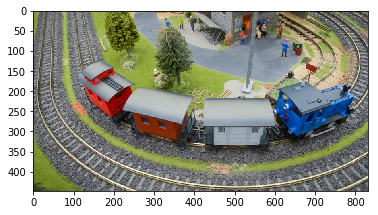

('Pyramid level: ', 0)
Iteration 0
inner loop
solving linear system
(448, 832, 2)
[0 1]
Initial Loss: 2238.2734375 + 10000 * 0.00378563915979 = 2276.1298291
Iteration 1
inner loop
solving linear system
(448, 832, 2)
[0 1]
Initial Loss: 1785.24499512 + 10000 * 0.00433127122736 = 1828.55770739
Iteration 2
inner loop
solving linear system
(448, 832, 2)
[0 1]
Initial Loss: 1424.67810059 + 10000 * 0.00439126678653 = 1468.59076845
Iteration 3
inner loop
solving linear system
(448, 832, 2)
[0 1]
Initial Loss: 1115.56066895 + 10000 * 0.00422119978714 = 1157.77266682
Iteration 4
inner loop
solving linear system
(448, 832, 2)
[0 1]
Initial Loss: 866.801757812 + 10000 * 0.00400359488434 = 906.837706656
Iteration 5
inner loop
solving linear system
(448, 832, 2)
[0 1]
Initial Loss: 694.776855469 + 10000 * 0.00379282745037 = 732.705129972
Iteration 6
inner loop
solving linear system
(448, 832, 2)
[0 1]
Initial Loss: 583.301208496 + 10000 * 0.00357709878041 = 619.0721963
Iteration 7
inner loop
solvin

In [8]:
hs = HornSchunck()

uv = hs.compute_flow(images, np.zeros((H, W, 2),dtype=np.float32), gt)
#uv = hs.compute_flow(images, np.zeros((H, W, 2),dtype=np.float32))

In [12]:
print hs.losses

[3047.00439453125, 2276.1298290979184, 1828.5577073908285, 1468.5907684512247, 1157.7726668166881, 906.8377066558544, 732.7051299724188, 619.0721963001944, 536.7411271210415, 469.90729566310716, 416.5362956412131, 374.27482953895054, 336.43070992746385, 305.4652756424123, 280.07556985643384, 254.31721219455235, 232.70746052803085, 221.3406351109503, 215.87596158940983, 211.92594540269724, 208.0504644113136, 205.0010917266304, 201.48952917630857, 196.44340137114997, 190.6335717361858, 186.3986766822438, 184.84424782201486, 184.1309675488899, 183.98360885723017, 184.08691119245293, 184.18271771250943]


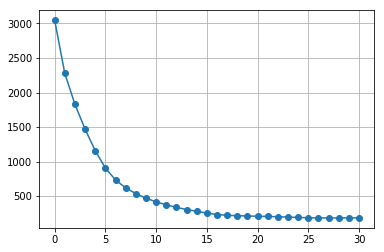

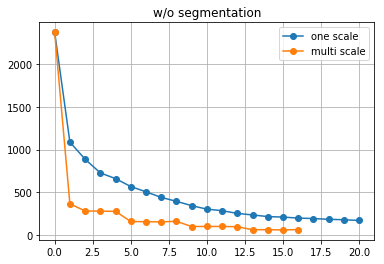

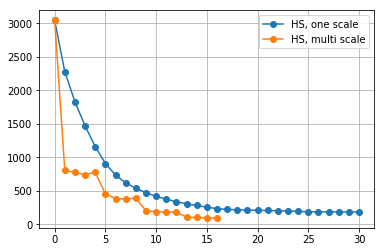

In [13]:
# 1 level 20 iterations, w/o segmentation, lambda = 200, bus
a = [2367.198486328125, 1086.9338908190311, 887.5689446570565, 728.280307470739, 661.6444949328082, 569.5988322365454, 507.9249628629853, 442.8875122190514, 397.13016714970547, 346.89726271163573, 305.92449750260124, 288.06006045053977, 256.43525012000003, 238.51343082299067, 219.30329675785754, 213.4030836351283, 201.7831635838088, 196.4742925216647, 187.588040737026, 182.30222453345107, 174.1319011558041]
# 153.331451416 + 200 * 0.104002248699 = 174.131901156
# 4 levels 4 iterations, w/o segmentation, lambda = 200, bus
b = [2367.198486328125, 367.48213496568127, 285.0987989756471, 282.40619103495777, 279.9439344337568, 162.11949588948656, 159.19669916791625, 157.49548873615814, 164.51183681950437, 103.1818493620897, 104.39184425958133, 104.19969923357567, 101.31880071154436, 65.96811217789697, 66.61345598414884, 63.913357781585624, 67.72272040713561]
# 60.3459129333 + 200 * 0.0368840373689 = 67.7227204071
# 1 levels 20 iterations, w/ segmentation, lambda = 200, bus
c = [2367.198486328125, 1085.9213058036667, 888.4133750011495, 730.3889899428647, 660.7337439517257, 569.5050003927724, 510.2032426949157, 444.6740029779763, 396.9812210742249, 349.4660385730239, 311.70571501499944, 288.32998208566823, 262.05109749275937, 247.63581022892748, 231.45076453603463, 217.65320379062263, 207.6169318359078, 203.99258795428824, 197.52580142642597, 190.18959769368956, 183.77088436773255]
# 162.019302368 + 200 * 0.108757909998 = 183.770884368
# 4 levels 4 iterations, w/ segmenation, lambda = 200, bus
d = [2367.198486328125, 349.2994799941821, 247.8504526520939, 247.74639394992872, 268.08916706555084, 176.42018566956133, 174.2500927542521, 188.6357770733513, 200.77080168552362, 149.9678237056758, 143.71827408253662, 139.8954918806607, 132.21527464326817, 94.73447178976795, 90.02762147097359, 88.85167371432503, 92.85295397579357]
# 84.7670288086 + 200 * 0.040429625836 = 92.8529539758

# 1 leve 20 iterations, w/ segmentation, lambda = 200, train, crop
e = [3047.00439453125, 1160.3674010085404, 1168.0016535575596, 768.9680201852264, 704.5715343332774, 536.5661859012613, 489.1011552755007, 411.1861457616269, 378.1633028367713, 335.62131613337925, 312.484135703843, 285.97678811911214, 267.83403402608843, 252.93662236286346, 245.38038140314424, 234.80801065864864, 226.3284177164756, 215.92107545541367, 211.73981383593417, 203.17683903671312, 201.5800922407431]
# 169.125305176 + 200 * 0.162273935325 = 201.580092241
# 1 leve 30 iterations, w/ segmentation, lambda = 200, train, crop
f = [3047.00439453125, 1160.3674010085404, 1168.0016535575596, 768.9680201852264, 704.5715343332774, 536.5661859012613, 489.1011552755007, 411.1861457616269, 378.1633028367713, 335.62131613337925, 312.484135703843, 285.97678811911214, 267.83403402608843, 252.93662236286346, 245.38038140314424, 234.80801065864864, 226.3284177164756, 215.92107545541367, 211.73981383593417, 203.17683903671312, 201.5800922407431, 194.93562103018218, 190.72417868081388, 185.801948726558, 182.71344402817255, 177.1839005682633, 174.65110366898548, 169.4439557496758, 170.92446176226753, 167.14178879017535, 165.6162434763435]
# 136.762939453 + 200 * 0.144266520116 = 165.616243476
# 1 leve 30 iterations, w/ segmentation, lambda = 10000, train, crop
g = [3047.00439453125, 2276.1298290979184, 1828.5577073908285, 1468.5907684512247, 1157.7726668166881, 906.8377066558544, 732.7051299724188, 619.0721963001944, 536.7411271210415, 469.90729566310716, 416.5362956412131, 374.27482953895054, 336.43070992746385, 305.4652756424123, 280.07556985643384, 254.31721219455235, 232.70746052803085, 221.3406351109503, 215.87596158940983, 211.92594540269724, 208.0504644113136, 205.0010917266304, 201.48952917630857, 196.44340137114997, 190.6335717361858, 186.3986766822438, 184.84424782201486, 184.1309675488899, 183.98360885723017, 184.08691119245293, 184.18271771250943]
# 171.631530762 + 10000 * 0.00125511869508 = 184.182717713
# 4 levels 4 iterations, w/ segmenation, lambda = 200, train, crop
h = [3047.00439453125, 807.0741130873631, 772.5313973546515, 741.2454081550815, 774.537146156962, 454.21900910465786, 381.941844309235, 375.2344555944369, 389.9364449537044, 200.5137032120985, 186.62323150281958, 182.41073817771064, 181.48242351487494, 104.0416577348208, 100.69978291832717, 94.54807037921401, 93.98240255497393]
# 82.5552368164 + 200 * 0.0571358286928 = 93.982402555

plt.figure()
plt.plot(hs.losses,'-o')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(a,'-o',label='one scale')
plt.plot(b,'-o',label='multi scale')
plt.grid(True)
plt.legend(loc='upper right')
plt.title('w/o segmentation')
plt.show()

plt.figure()
plt.plot(g,'-o',label='HS, one scale')
plt.plot(h,'-o',label='HS, multi scale')
plt.grid(True)
plt.legend(loc='upper right')
#plt.title('w/ segmentation')
plt.show()

max flow: 12.0140
flow range:
u = -4.969 .. 8.222
v = -12.000 .. 3.206
max flow: 12.0140
flow range:
u = -4.969 .. 8.222
v = -12.000 .. 3.206


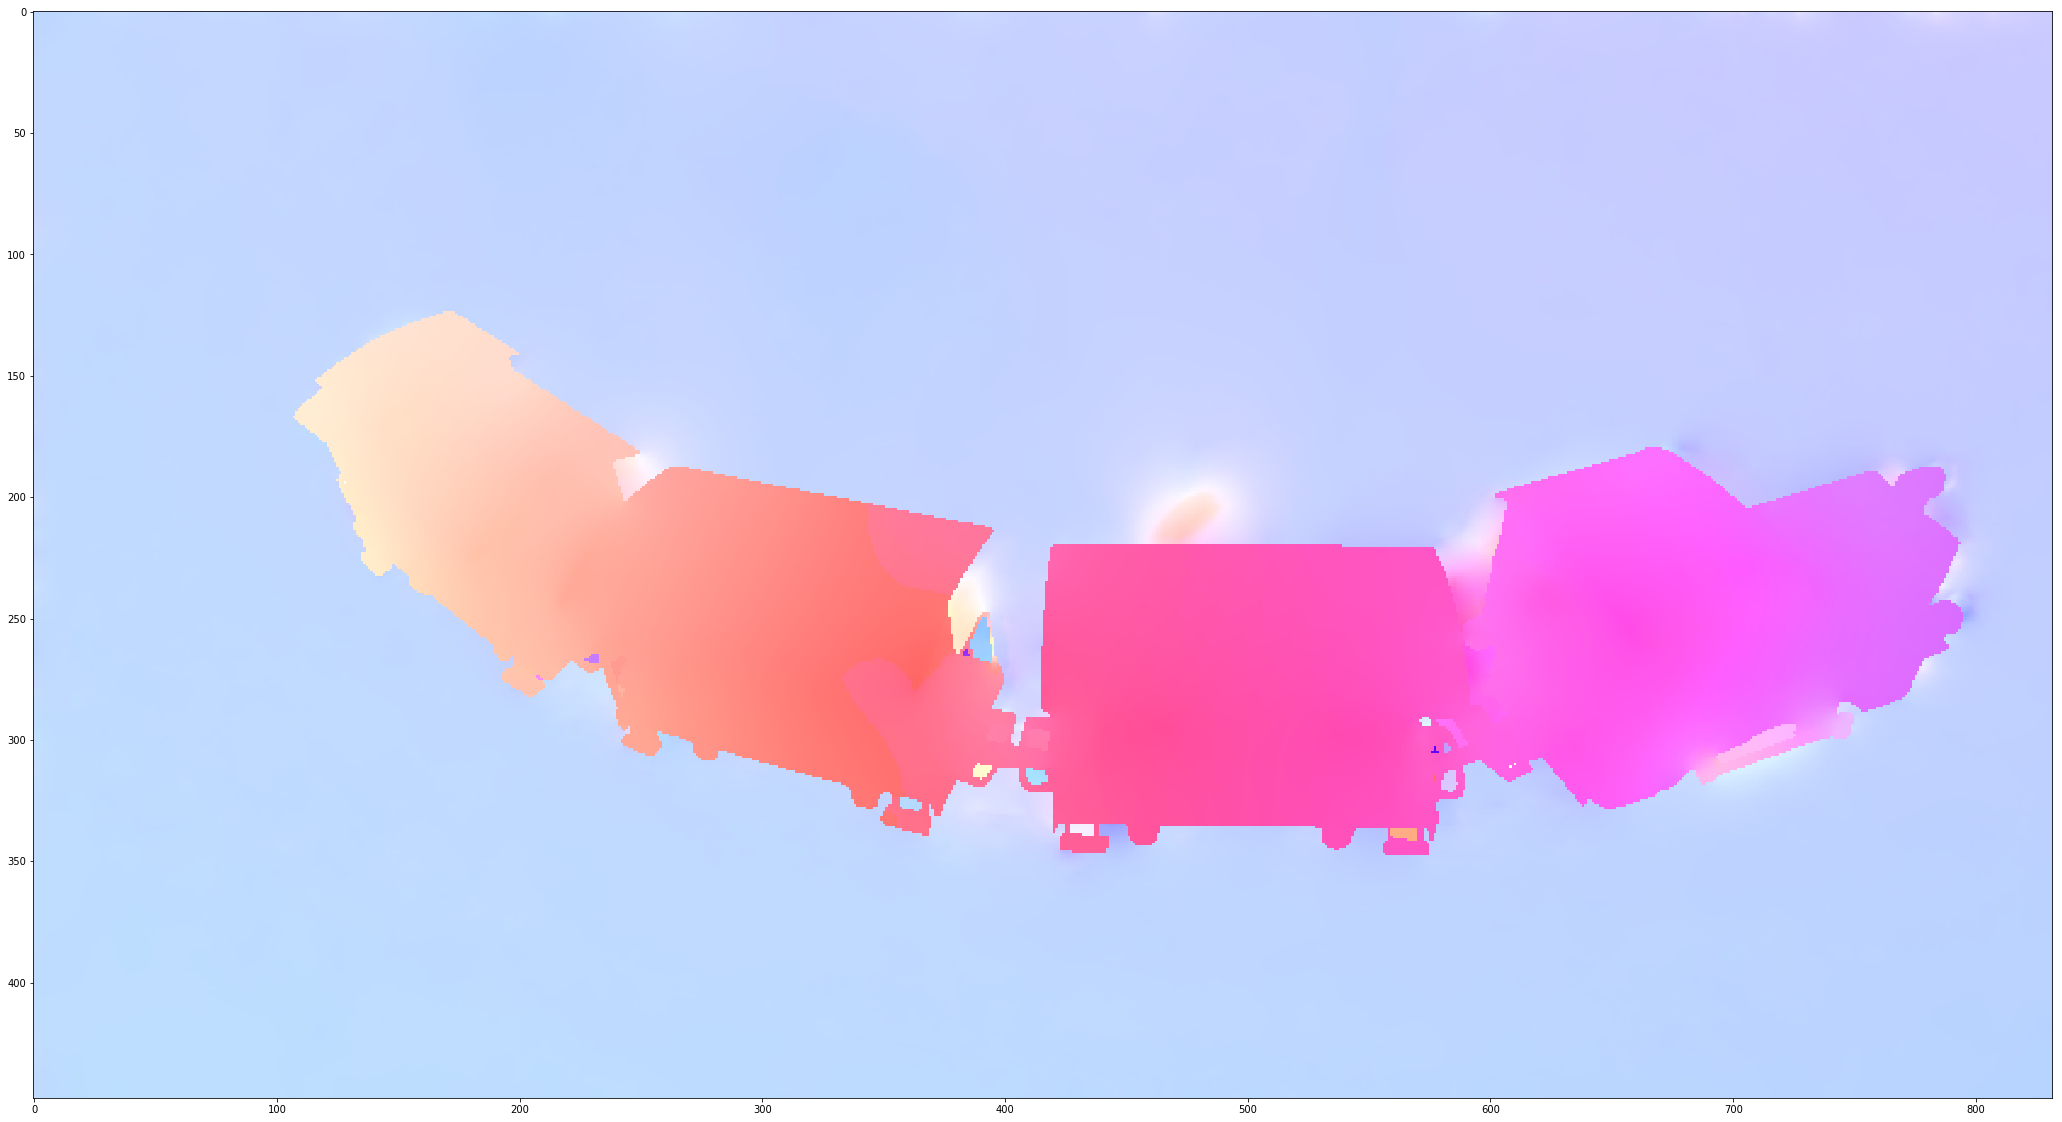

In [14]:
plt.figure(figsize=(40, 20))
#plt.imshow(flow_to_image(uv))
plt.imshow(flow_to_image(np.clip(uv, -12, 12)))
#plt.imshow(flow_to_image((uv)))
plt.imsave('result.png',flow_to_image(np.clip(uv, -12, 12)))
#plt.imsave('bus00023_4level_4iter_wseg.png',flow_to_image(uv))